In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-rc2'

### dataset API

https://blog.csdn.net/feixiang7701/article/details/81611356

#### dataset 的属性

dataset 可以通过element_spec查看形状和数据dtype

In [2]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(0,9))

In [3]:
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

In [4]:
def test_dataset_conv2d(ds,out_size,last_activation,loss):
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(filters = 6,kernel_size=5,activation="sigmoid"),
        tf.keras.layers.MaxPooling2D(strides = 2),
        tf.keras.layers.Conv2D(filters = 16,kernel_size=5,activation="sigmoid"),
        tf.keras.layers.MaxPooling2D(strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32,activation="sigmoid"),
        tf.keras.layers.Dense(out_size,activation=last_activation)
    ])
    
    model.compile(loss=loss,metrics=["acc"])
    
    model.fit(ds,epochs=3,steps_per_epoch=10)

#### 数据读取
可以通过from_tensor_slices,from_tensors,from_generator

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
dataset_1 = tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [7]:
def map_fun(x,y):
    x = tf.divide(x,255)
    x = tf.expand_dims(x,axis=-1)
    return x,y

In [8]:
dataset_1 = dataset_1.map(map_func=map_fun).batch(256)

In [9]:
test_dataset_conv2d(dataset_1,10,last_activation="softmax",loss=tf.losses.sparse_categorical_crossentropy)

Train for 10 steps
Epoch 1/3
10/10 [==============================] - 1s 100ms/step - loss: 2.3611 - acc: 0.1055
Epoch 2/3
10/10 [==============================] - 0s 44ms/step - loss: 2.3069 - acc: 0.1027
Epoch 3/3
10/10 [==============================] - 0s 44ms/step - loss: 2.3077 - acc: 0.0871


### 读取Numpy

In [10]:
import numpy as np

In [11]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
path = tf.keras.utils.get_file("mnist.npz",DATA_URL)

In [12]:
with np.load(path) as data:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

In [13]:
dataset_2 = tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [14]:
dataset_2 = dataset_2.map(map_func=map_fun)
dataset_2 = dataset_2.batch(256).shuffle(100)

In [15]:
test_dataset_conv2d(dataset_1,10,last_activation="softmax",loss=tf.losses.sparse_categorical_crossentropy)

Train for 10 steps
Epoch 1/3
10/10 [==============================] - 1s 92ms/step - loss: 2.3233 - acc: 0.1055
Epoch 2/3
10/10 [==============================] - 0s 50ms/step - loss: 2.3040 - acc: 0.1063
Epoch 3/3
10/10 [==============================] - 0s 47ms/step - loss: 2.3021 - acc: 0.1027


### Image

In [16]:
DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(fname="flower_photos",origin=DATA_URL,untar=True)

In [17]:
data_dir

'C:\\Users\\Administrator\\.keras\\datasets\\flower_photos'

In [18]:
import pathlib

In [19]:
data_dir = pathlib.Path(data_dir)

In [20]:
dataset_2 = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [21]:
for data in dataset_2.take(2):
    print(data)

tf.Tensor(b'C:\\Users\\Administrator\\.keras\\datasets\\flower_photos\\sunflowers\\274848710_5185cf33b1_n.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\Administrator\\.keras\\datasets\\flower_photos\\daisy\\11642632_1e7627a2cc.jpg', shape=(), dtype=string)


#### 构建标签

In [22]:
class_lable =  np.array([ item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt" ])
class_lable

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [23]:
## 转换lable为数值型数据
lable_dic =dict( zip(class_lable,np.asarray(range(0,len(class_lable)))))
lable_dic

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

#### dataset 变换

In [24]:
@tf.function
def get_lable(path):
    parts = tf.strings.split(path,"\\")
    return parts[-2] == class_lable

In [25]:
get_lable(tf.constant("C:\\Users\\Administrator\\.keras\\datasets\\flower_photos\\daisy\\3117644024_1cbb59a509_n.jpg",dtype=tf.string))

<tf.Tensor: id=2186, shape=(5,), dtype=bool, numpy=array([ True, False, False, False, False])>

In [26]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [27]:
def decode_img(img):
    img = tf.image.decode_image(img,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img,IMG_WIDTH,IMG_HEIGHT)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img

In [28]:
def img_map_fun(x):
    lable = get_lable(x)
    img = tf.io.read_file(x)
    img = decode_img(img)
    return img,lable

In [29]:
lable = tf.constant([0,1,2,3,4])
@tf.function
def map_lable_fun(x,y):
    print(y)
    y = lable[y][0]
    return x,y

In [30]:
dataset_2 = dataset_2.map(map_func=img_map_fun,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [31]:
dataset_2 = dataset_2.map(map_func=map_lable_fun)

Tensor("y:0", shape=(5,), dtype=bool)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000,batch_size = 256):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [33]:
dataset_2 = prepare_for_training(dataset_2)

In [34]:
image_batch, label_batch = next(iter(dataset_2))

In [35]:
import matplotlib.pyplot as plt

In [36]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_lable[label_batch[n]].title())
        plt.axis('off')

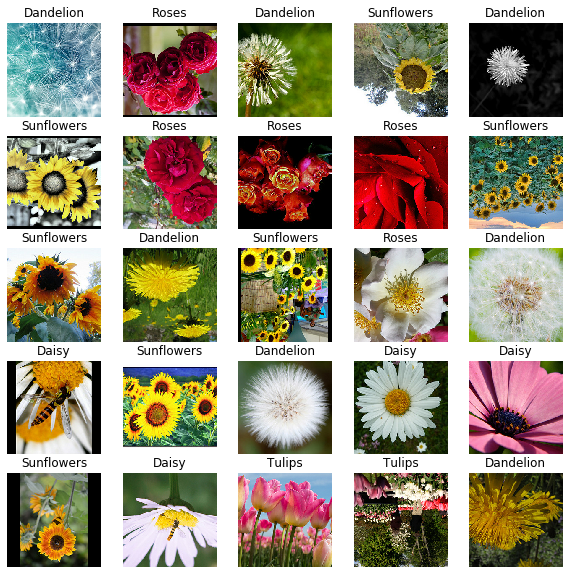

In [37]:
show_batch(image_batch.numpy(),label_batch.numpy())

In [38]:
test_dataset_conv2d(dataset_2,5,"softmax",tf.keras.losses.sparse_categorical_crossentropy)

Train for 10 steps
Epoch 1/3
10/10 [==============================] - 47s 5s/step - loss: 2.1288 - acc: 0.1801
Epoch 2/3
10/10 [==============================] - 44s 4s/step - loss: 2.0260 - acc: 0.1707
Epoch 3/3
10/10 [==============================] - 45s 5s/step - loss: 1.9678 - acc: 0.1691


#### 读取pandas.DataFrame

In [40]:
import pandas as pd

In [39]:
heart_url = "https://storage.googleapis.com/applied-dl/heart.csv"

heart_dir = tf.keras.utils.get_file(fname="heart.csv",origin=heart_url)

16384/13273 [=====================================] - 0s 4us/step


In [86]:
df_heart =  pd.read_csv(heart_dir)
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [87]:
df_heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.594059,0.676568,3.108911,131.785479,246.547855,0.148515,0.990099,149.194719,0.326733,1.057756,1.590759,0.683168,0.273927
std,9.016370,0.468560,1.028414,17.748338,52.175933,0.356198,0.988293,23.173368,0.469794,1.165025,0.617767,0.937773,0.446710
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [88]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null object
target      303 non-null int64
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [89]:
# 将类别数据数值化
df_heart['thal'] = pd.Categorical(df_heart['thal'])
df_heart['thal']

0           fixed
1          normal
2      reversible
3          normal
4          normal
          ...    
298         fixed
299    reversible
300    reversible
301    reversible
302    reversible
Name: thal, Length: 303, dtype: category
Categories (5, object): [1, 2, fixed, normal, reversible]

In [90]:
df_heart['thal'] =  df_heart['thal'].cat.codes

In [91]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [92]:
lable = df_heart.pop("target")
lable.head()

0    0
1    1
2    0
3    0
4    0
Name: target, dtype: int64

In [93]:
dataset_3 = tf.data.Dataset.from_tensor_slices((df_heart.values,lable.values))

In [94]:
dataset_3 = dataset_3.shuffle(len(df_heart)).batch(1)

In [95]:
x,y = next(iter(dataset_3))
x,y

(<tf.Tensor: id=45998, shape=(1, 13), dtype=float64, numpy=
 array([[ 56.,   1.,   2., 130., 221.,   0.,   2., 163.,   0.,   0.,   1.,
           0.,   4.]])>,
 <tf.Tensor: id=45999, shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>)

In [96]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(10,activation = "relu"),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [97]:
model.compile(loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"],optimizer="adam")

In [99]:
steps_per_epoch = len(df_heart) // 16
model.fit(dataset_3,epochs=10)

Epoch 1/10
303/303 [==============================] - 1s 3ms/step - loss: 0.4705 - accuracy: 0.7690
Epoch 2/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4576 - accuracy: 0.7855
Epoch 3/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4671 - accuracy: 0.7789
Epoch 4/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4527 - accuracy: 0.8251
Epoch 5/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4508 - accuracy: 0.7888
Epoch 6/10
303/303 [==============================] - 0s 1ms/step - loss: 0.5038 - accuracy: 0.7888
Epoch 7/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4907 - accuracy: 0.8020
Epoch 8/10
303/303 [==============================] - 0s 1ms/step - loss: 0.5335 - accuracy: 0.7525
Epoch 9/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.8053
Epoch 10/10
303/303 [==============================] - 0s 1ms/step - loss: 0.4684 - accuracy: 0.7954

### 读取cvs文件
如果是大文件使用tf.data.experimental.make_csv_dataset函数

In [119]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
train_data_dir = tf.keras.utils.get_file(fname="titanic_train.csv",origin=TRAIN_DATA_URL)
train_data_dir

32768/30874 [===============================] - 0s 14us/step


'C:\\Users\\Administrator\\.keras\\datasets\\titanic_train.csv'

In [120]:
## 先观察下文件
!head {train_data_dir}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [121]:
LABEL_COLUMN = "survived"
LABEL_VALUES = [0,1]

In [122]:
BATCH_SIZE = 16

In [126]:
dataset_4 = tf.data.experimental.make_csv_dataset(file_pattern=train_data_dir,batch_size=5,label_name=LABEL_COLUMN,num_epochs=15,ignore_errors=True,na_value="?")

In [127]:
# 查看dataset
def show_dataset(ds):
    for batch,lable in ds.take(1):
        for keys,values in batch.items():
            print("{:20s}:{}".format(keys,values.numpy()))

In [128]:
show_dataset(dataset_4)

sex                 :[b'male' b'male' b'male' b'male' b'male']
age                 :[21. 28. 28. 41.  1.]
n_siblings_spouses  :[0 0 0 0 4]
parch               :[0 0 0 0 1]
fare                :[ 7.925   7.8958  6.8583  7.125  39.6875]
class               :[b'Third' b'Third' b'Third' b'Third' b'Third']
deck                :[b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         :[b'Southampton' b'Southampton' b'Queenstown' b'Southampton' b'Southampton']
alone               :[b'y' b'y' b'y' b'y' b'n']


#### 处理数值型数据

In [132]:
NUMBERIC_FEATURE = ["age","fare","n_siblings_spouses","parch"]

In [134]:
class PackNumbericFeature(object):
    def __init__(self,names):
        self.names = names
    
    def __call__(self,features,lables):
        numeric_features = [ features.pop(name) for name in self.names ]
        # 数据类型转换
        numeric_features =[ tf.cast(feat,dtype=tf.float32) for feat in numeric_features ]
        
        numeric_features = tf.stack(numeric_features,axis=-1)
        
        features["numeric"] = numeric_features
        return features,lables

In [135]:
dataset_4 = dataset_4.map(PackNumbericFeature(NUMBERIC_FEATURE))

In [136]:
show_dataset(dataset_4)

sex                 :[b'male' b'male' b'male' b'male' b'male']
class               :[b'Third' b'Third' b'Third' b'Third' b'Third']
deck                :[b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         :[b'Southampton' b'Southampton' b'Queenstown' b'Southampton' b'Southampton']
alone               :[b'y' b'y' b'y' b'y' b'n']
numeric             :[[21.      7.925   0.      0.    ]
 [28.      7.8958  0.      0.    ]
 [28.      6.8583  0.      0.    ]
 [41.      7.125   0.      0.    ]
 [ 1.     39.6875  4.      1.    ]]


In [146]:
example_batch, labels_batch = next(iter(dataset_4))

In [147]:
example_batch, labels_batch

(OrderedDict([('sex',
               <tf.Tensor: id=65708, shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>),
              ('class',
               <tf.Tensor: id=65704, shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'Third', b'Third', b'Third'], dtype=object)>),
              ('deck', <tf.Tensor: id=65705, shape=(5,), dtype=string, numpy=
               array([b'unknown', b'unknown', b'unknown', b'unknown', b'unknown'],
                     dtype=object)>),
              ('embark_town',
               <tf.Tensor: id=65706, shape=(5,), dtype=string, numpy=
               array([b'Southampton', b'Southampton', b'Queenstown', b'Southampton',
                      b'Southampton'], dtype=object)>),
              ('alone',
               <tf.Tensor: id=65703, shape=(5,), dtype=string, numpy=array([b'y', b'y', b'y', b'y', b'n'], dtype=object)>),
              ('numeric',
               <tf.Tensor: id=65707, shape=(5, 4), dtype=

#### 归一化

In [137]:
titanic_df = pd.read_csv(train_data_dir)
desc = titanic_df[NUMBERIC_FEATURE].describe()
desc

,age,fare,n_siblings_spouses,parch
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,34.385399,0.545455,0.379585
std,12.511818,54.597730,1.151090,0.792999
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,7.895800,0.000000,0.000000
50%,28.000000,15.045800,0.000000,0.000000
75%,35.000000,31.387500,1.000000,0.000000
max,80.000000,512.329200,8.000000,5.000000


In [139]:
mean = desc.T["mean"]
mean

age                   29.631308
fare                  34.385399
n_siblings_spouses     0.545455
parch                  0.379585
Name: mean, dtype: float64

In [140]:
std = desc.T["std"]
std

age                   12.511818
fare                  54.597730
n_siblings_spouses     1.151090
parch                  0.792999
Name: std, dtype: float64

In [141]:
def normalize_numeric_data(data,mean,std):
    return (data - mean)/std

In [142]:
import functools

In [143]:
normalizer = functools.partial(normalize_numeric_data,mean = mean,std = std)

In [144]:
numeric_column = tf.feature_column.numeric_column("numeric",normalizer_fn=normalizer,shape=[(len(NUMBERIC_FEATURE))])
numeric_columns = [numeric_column]
numeric_columns

[NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x000002205779B1E0>, mean=age                   29.631308
 fare                  34.385399
 n_siblings_spouses     0.545455
 parch                  0.379585
 Name: mean, dtype: float64, std=age                   12.511818
 fare                  54.597730
 n_siblings_spouses     1.151090
 parch                  0.792999
 Name: std, dtype: float64))]

In [148]:
example_batch['numeric']

<tf.Tensor: id=65707, shape=(5, 4), dtype=float32, numpy=
array([[21.    ,  7.925 ,  0.    ,  0.    ],
       [28.    ,  7.8958,  0.    ,  0.    ],
       [28.    ,  6.8583,  0.    ,  0.    ],
       [41.    ,  7.125 ,  0.    ,  0.    ],
       [ 1.    , 39.6875,  4.    ,  1.    ]], dtype=float32)>

In [149]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch)

<tf.Tensor: id=65721, shape=(5, 4), dtype=float32, numpy=
array([[-0.6898524 , -0.48464286, -0.47385937, -0.4786705 ],
       [-0.13038135, -0.48517767, -0.47385937, -0.4786705 ],
       [-0.13038135, -0.5041803 , -0.47385937, -0.4786705 ],
       [ 0.90863633, -0.49929547, -0.47385937, -0.4786705 ],
       [-2.288341  ,  0.09711212,  3.0011094 ,  0.7823648 ]],
      dtype=float32)>

#### 处理类别数据

In [150]:
CATE_FEATURES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [155]:
cate_features = []
for cate,vocab in CATE_FEATURES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(cate,vocab)
    cate_features.append(tf.feature_column.indicator_column(cat_col))

In [156]:
cate_layer = tf.keras.layers.DenseFeatures(cate_features)
cate_layer(example_batch)

<tf.Tensor: id=66086, shape=(5, 20), dtype=float32, numpy=
array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.]], dtype=float32)>

In [157]:
preprocessing_layer = tf.keras.layers.DenseFeatures(numeric_columns+cate_features)

In [158]:
preprocessing_layer(example_batch)

<tf.Tensor: id=66280, shape=(5, 24), dtype=float32, numpy=
array([[ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.6898524 , -0.48464286,
        -0.47385937, -0.4786705 ,  1.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.13038135, -0.48517767,
        -0.47385937, -0.4786705 ,  1.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.     

In [159]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [160]:
train_data = dataset_4.shuffle(500)

In [161]:
model.fit(train_data,epochs=20)

Epoch 1/20
1881/1881 [==============================] - 7s 4ms/step - loss: 0.3702 - accuracy: 0.8421
Epoch 2/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2965 - accuracy: 0.8758
Epoch 3/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2684 - accuracy: 0.8896
Epoch 4/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2500 - accuracy: 0.8974
Epoch 5/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2389 - accuracy: 0.9004
Epoch 6/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2248 - accuracy: 0.9080
Epoch 7/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2162 - accuracy: 0.9109
Epoch 8/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2061 - accuracy: 0.9143
Epoch 9/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.1976 - accuracy: 0.9206
Epoch 10/20
1881/1881 [==============================] - 3s 2ms/step - loss: 0.194